In [37]:
import numpy as np
import matplotlib.pyplot as plt
import string
rupi = open('rupi-kaur-poetry-master/rupis/rupi0.txt')

In [2]:
transitions = {}
row_sums = {}
for line in open('machine_learning_examples-master/hmm_class/site_data.csv'):
    s, e = line.rstrip().split(',')
    transitions[(s,e)] = transitions.get((s,e),0) + 1
    row_sums[s] = row_sums.get(s,0) + 1
for k, v in transitions.items():
    s, e = k
    transitions[k] = v / row_sums[s]
print("initial state distribution")
for k, v in transitions.items():
    s, e = k
    if s =="-1":
        print(e, v)

initial state distribution
8 0.10152591025834719
2 0.09507982071813466
5 0.09779926474291183
9 0.10384247368686106
0 0.10298635241980159
6 0.09800070504104345
7 0.09971294757516241
1 0.10348995316513068
4 0.10243239159993957
3 0.09513018079266758


In [3]:
def remove_punctuation(s):
    return s.translate(s.maketrans({k:"" for k in string.punctuation}))
tokens = [t for t in remove_punctuation(line.rstrip().lower()).split()]
def add2dict(d,k,v):
    if k not in d:
        d[k] = []
    d[k].append(v)
def list2pdict(ts):
    d = {}
    n = len(ts)
    for t in ts:
        d[t] = d.get(t, 0) + 1
    for t, c in d.items():
        d[t] = c / n
    return d
def sample_word(d):
    p0 = np.random.random()
    cumulative = 0
    for t, p in d.items():
        cumulative += p
        if p0 < cumulative:
            return t
    assert(False)

In [4]:
initial = {}
second_word = {}
transitions = {}
for line in rupi:#open('machine_learning_examples-master/hmm_class/robert_frost.txt'):
    tokens = [t for t in remove_punctuation(line.rstrip().lower()).split()]
    T = len(tokens)
    for i in range(T):
        t = tokens[i]
        if i == 0:
            initial[t] = initial.get(t, 0) + 1
        else:
            t_1 = tokens[i - 1]
            if i == T - 1:
                add2dict(transitions, (t_1,t),'END')
            if i == 1:
                add2dict(second_word, t_1, t)
            else:
                t_2 = tokens[i-2]
                add2dict(transitions, (t_2, t_1), t)
                
initial_total = sum(initial.values())
for t, c in initial.items():
    initial[t] = c / initial_total
for t_1,ts in second_word.items():
    second_word[t_1] = list2pdict(ts)
for k, ts in transitions.items():
    transitions[k] = list2pdict(ts)
    
def generate(N_line):
    for i in range(N_line):
        sentence = []
        w0 = sample_word(initial)
        sentence.append(w0)
        w1 = sample_word(second_word[w0])
        sentence.append(w1)
        while 1:
            w2 = sample_word(transitions[(w0,w1)])
            if w2 == 'END':
                break
            sentence.append(w2)
            w0 = w1
            w1 = w2
        print(' '.join(sentence))

In [19]:
generate(4)

the name runs in my blood
it always comes back to you
with his lips
all the wrong people


In [26]:
generate(4)

i stand up
she was a rose
my favorite thing about you is your smell
the difference


In [36]:
generate(4)

he was the becoming of myself
its way back to you
and here you are not enough for yourself
it is my identity and my god


## Discrete HMM

In [38]:
def random_normalized(d1,d2):
    x = np.random.random((d1,d2))
    return x / x.sum(axis=1,keepdims=True)

it: 0
it: 10


/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in multiply
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


it: 20
A: [[nan nan]
 [nan nan]]
B: [[nan nan]
 [nan nan]]
pi: [nan, nan]


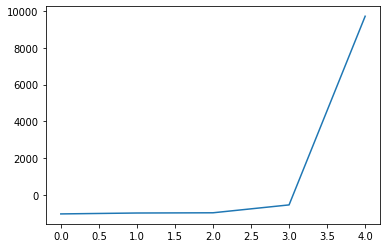

nan
-1059.7229160265022
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


In [85]:
class HMM:
    def __init__(self,M):
        self.M = M
    def fit(self,X, max_iter = 30):
        np.random.seed(123)
        V = max(max(x) for x in X) + 1
        N = len(X)
        self.pi = np.ones(self.M) / self.M
        self.A = random_normalized(self.M,self.M)
        self.B = random_normalized(self.M, V)
        
        costs = []
        for it in range(max_iter):
            if it % 10 == 0:
                print("it:", it)
            alphas = []
            betas = []
            P = np.zeros(N)
            for n in range(N):
                x = X[n]
                T = len(x)
                alpha = np.zeros((T,self.M))
                alpha[0] = self.pi * self.B[:,x[0]]
                for t in range(1,T):
                    alpha[t] = alpha[t-1].dot(self.A)*self.B[:,x[t]]
                P[n] = alpha[-1].sum()
                alphas.append(alpha)
                
                beta = np.zeros((T,self.M))
                beta[-1] = 1
                for t in range(T-2,-1,-1):
                    beta[t] = self.A.dot(self.B[:,x[t+1]])*beta[t+1]
                betas.append(beta)
            cost = np.sum(np.log(P))
            costs.append(cost)
            
            self.pi = [np.sum(alphas[n][0] * betas[n][0]) / P[n] for n in range(V)]
            den1 = np.zeros((self.M, 1))
            den2 = np.zeros((self.M, 1))
            a_num = 0
            b_num = 0
            for n in range(N):
                x = X[n]
                T = len(x)
                
                den1 += (alphas[n][:-1]*betas[n][:-1]).sum(axis=0,keepdims=True).T / P[n]
                den2 += (alphas[n]*betas[n]).sum(axis=0,keepdims=True).T / P[n]
                a_num_n = np.zeros((self.M, self.M))
                for i in range(self.M):
                    for j in range(self.M):
                        for t in range(T-1):
                            a_num_n[i,j] += alphas[n][t,i] * self.A[i,j] *self.B[j, x[t+1]]*betas[n][t+1,j]
                a_num += a_num_n / P[n]
                b_num_n = np.zeros((self.M,V))
                for i in range(self.M):
                    for j in range(V):
                        for t in range(T):
                            if x[t] == j:
                                b_num_n[i,j] += alphas[n][t,i] * betas[n][t,i]
                b_num += b_num_n / P[n]
            self.A = a_num / den1
            self.B = b_num / den2
        print("A:",self.A)
        print("B:",self.B)
        print("pi:",self.pi)
        plt.plot(costs)
        plt.show()
    def like(self,x):
        T = len(x)
        alpha = np.zeros((T,self.M))
        alpha[0] = self.pi*self.B[:,x[0]]
        for t in range(1,T):
            alpha[t] = alpha[t-1].dot(self.A)*self.B[:, x[t]]
        return alpha[-1].sum()
    def like_multi(self,X):
        return np.array([self.like(x) for x in X])
    def llmulti(self,X):
        return np.log(self.like_multi(X))
    def get_state_sequence(self,x):
        T = len(x)
        delta = np.zeros((T,self.M))
        psi = np.zeros((T,self.M))
        delta[0] = self.pi*self.B[:,x[0]]
        for t in range(1,T):
            for j in range(self.M):
                delta[t,j] = np.max(delta[t-1]*self.A[:,j])*self.B[j,x[t]]
                psi[t,j] = np.argmax(delta[t-1]*self.A[:,j])
        states = np.zeros(T,dtype=np.int32)
        states[T-1] = np.argmax(delta[T-1])
        for t in range(T-2,-1,-1):
            states[t] = psi[t+1,states[t+1]]
        return states
#def fit_coin():
X = []
for line in open('machine_learning_examples-master/hmm_class/coin_data.txt'):
    x = [1 if e == 'H' else 0 for e in line.rstrip()]
    X.append(x)
hmm = HMM(2)
hmm.fit(X)
L = hmm.llmulti(X).sum()
print(L)
hmm.pi = np.array([0.5,0.5])
hmm.A = np.array([[0.1,0.9],[0.8,0.2]])
hmm.B = np.array([[0.6,0.4],[0.3,0.7]])
L = hmm.llmulti(X).sum()
print(L)
print(hmm.get_state_sequence(X[0]))